Edge Filter
======
We show that a network can learn a simple edge filter with a single convolution


In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 0
batch_size = 512
learning_rate = 1e-1
use_gpu = True

CIFAR Data Loading
-------------------

The CIFAR dataset contains 60000 32x32 colour images, split into 50000 training images and 10000 test images. Each image is labeled as one of either 10 (CIFAR10) or 100 (CIFAR100) classes, but we are not using the labels here.

In [11]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10

gt_edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
gt_edge_filter.weight.data = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).view(1, 1, 3, 3)

def edge_filter(img):
    return gt_edge_filter(Variable(img.unsqueeze(0))).data.squeeze(0)

class EdgeImageDataset(Dataset):
    
    def __init__(self, root, train=True):
        self.cifar = CIFAR10(root=root, train=train, transform=None, target_transform=None, download=True)
        
        self.img_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
        
        self.img2edge_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Lambda(edge_filter)
        ])
    
    def __getitem__(self, index):
        img = self.cifar[index][0]
        return (self.img_transform(img), self.img2edge_transform(img))
        
    def __len__(self):
        return len(self.cifar)

train_dataset = EdgeImageDataset('./data/CIFAR10', train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EdgeImageDataset('./data/CIFAR10', train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Edge Filter Definition
-----------------------

In [4]:
class EdgeNet(nn.Module):
    def __init__(self, d=128):
        super(EdgeNet, self).__init__()
        
        # we are not using bias in this convolution, so that the learned kernel
        # can be compared with the ground truth edge kernel
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

    def forward(self, input):
        return self.conv(input)

enet = EdgeNet()
if use_gpu:
    enet = enet.cuda()

num_params = sum(p.numel() for p in enet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 9


Train Edge Filter
--------


In [5]:
optimizer = torch.optim.Adam(params=enet.parameters(), lr=learning_rate)

# set to training mode
enet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, edge_batch in train_dataloader:
        
        image_batch = Variable(image_batch)
        edge_batch = Variable(edge_batch)
        if use_gpu:
            image_batch = image_batch.cuda()
            edge_batch = edge_batch.cuda()
        
        # predict edges given the image
        predicted_edge_batch = enet(image_batch)
        
        # loss is the L2 error to the actual edges
        loss = F.mse_loss(predicted_edge_batch, edge_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.data[0]
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average reconstruction error: 0.048946
Epoch [2 / 10] average reconstruction error: 0.000699
Epoch [3 / 10] average reconstruction error: 0.000202
Epoch [4 / 10] average reconstruction error: 0.000047
Epoch [5 / 10] average reconstruction error: 0.000011
Epoch [6 / 10] average reconstruction error: 0.000003
Epoch [7 / 10] average reconstruction error: 0.000001
Epoch [8 / 10] average reconstruction error: 0.000000
Epoch [9 / 10] average reconstruction error: 0.000000
Epoch [10 / 10] average reconstruction error: 0.000000


Plot Training Curves
--------------------

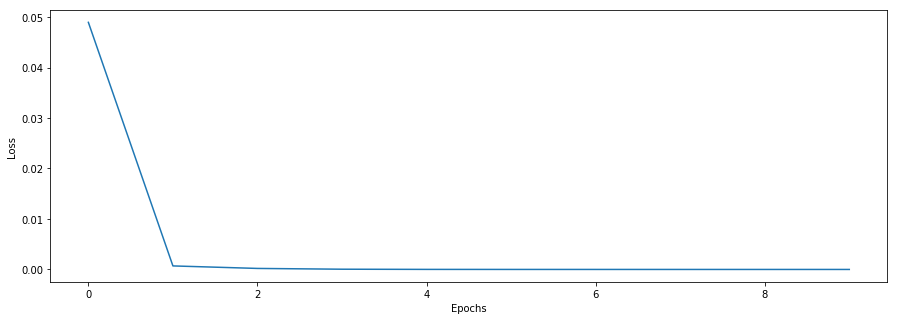

In [12]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained Color Regressor
-----------------------------

In [7]:
enet.load_state_dict(torch.load('./pretrained/edge_net.pth'))

# this is how the model parameters can be saved:
# torch.save(enet.state_dict(), './pretrained/my_edge_net.pth')

Evaluate on the Test Set
----------------------------

In [13]:
# set to evaluation mode
enet.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, edge_batch in train_dataloader:

    image_batch = Variable(image_batch)
    edge_batch = Variable(edge_batch)
    if use_gpu:
        image_batch = image_batch.cuda()
        edge_batch = edge_batch.cuda()

    # predict edges given the image
    predicted_edge_batch = enet(image_batch)

    # loss is the L2 error to the actual edges
    loss = F.mse_loss(predicted_edge_batch, edge_batch)

    test_loss_avg += loss.data[0]
    num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 0.000000


Show Random Edge Images from the Test Set
-------------------------------------------------


learned edge filter
[[[[ 0.9988411   0.00214587 -1.0011405 ]
   [ 2.002173   -0.00401726 -1.9978483 ]
   [ 0.9988188   0.00219029 -1.0011786 ]]]]
ground truth edge filter
[[[[ 1.  0. -1.]
   [ 2.  0. -2.]
   [ 1.  0. -1.]]]]


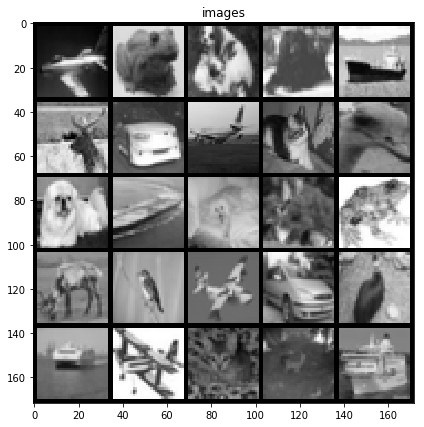

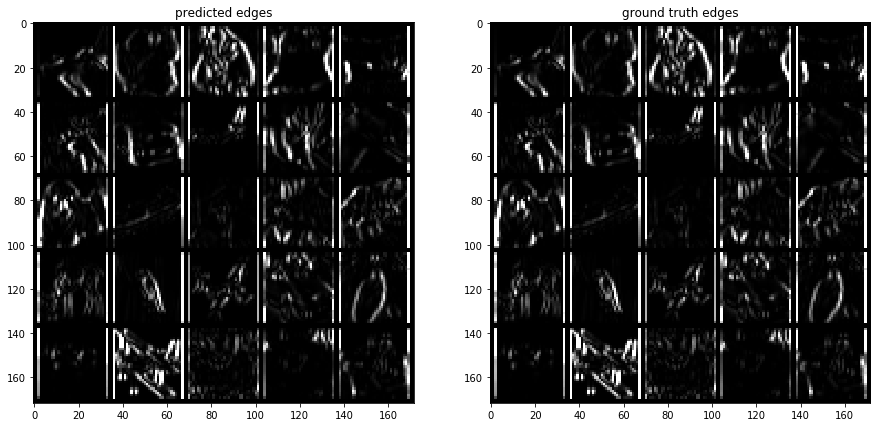

In [14]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

# pick a random subset of images from the test set
image_inds = np.random.choice(len(test_dataset), 25, replace=False)
image_batch = torch.stack([test_dataset[i][0] for i in image_inds])
edge_batch = torch.stack([test_dataset[i][1] for i in image_inds])

image_batch = Variable(image_batch)
if use_gpu:
    image_batch = image_batch.cuda()
    
# predict edges
predicted_edge_batch = enet(image_batch)

if use_gpu:
    image_batch = image_batch.cpu()
    predicted_edge_batch = predicted_edge_batch.cpu()
image_batch = image_batch.data
predicted_edge_batch = predicted_edge_batch.data

# get edge magnitudes in [0,1]
predicted_edge_batch = ((predicted_edge_batch/4.0).pow(2)*4.0).clamp(min=0, max=1)
edge_batch = ((edge_batch/4.0).pow(2)*4.0).clamp(min=0, max=1)

print('learned edge filter')
print(enet.conv.weight.data.cpu().numpy())

print('ground truth edge filter')
print(gt_edge_filter.weight.data.numpy())

# plot images
fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
ax.imshow(np.transpose(torchvision.utils.make_grid(torch.stack(image_batch), nrow=5).numpy(), (1, 2, 0)))
ax.title.set_text('images')

# plot edges
fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_edge_batch), nrow=5).numpy(), (1, 2, 0)))
ax[0].title.set_text('predicted edges')
ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(edge_batch), nrow=5).numpy(), (1, 2, 0)))
ax[1].title.set_text('ground truth edges')
plt.show()
